# Notebook to Identify Representative Molecules of 2CzPN

This notebook uses a hierarchical clustering approach based on the cost function $J$ to identify a small number of similar molecules out of a larger set of disordered molecules of 2CzPN. 

In [1]:
import os

# the directory containing the structures
structure_dir = 'extracted_structures'

# seedname to be used for calculation files
seed = '2CzPN'

# the total number of molecules (the full set consists of 500 molecules)
nmol = 50

# the number of atoms in a single molecule
nat_frag = 54

%matplotlib inline

Read in each molecule as a single fragment using PyBigDFT.

In [2]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment, RotoTranslation
from BigDFT.IO import XYZReader

def read_as_frag(filename):
    sys = System()
    sys["FRAG:"+str(0)] = Fragment()
    
    with XYZReader(filename+'.xyz') as ifile:
        for i, at in enumerate(ifile):
            sys["FRAG:"+str(0)].append(at)    
    return sys

structures = []
filenames = [structure_dir+'/'+seed+'_'+str(i + 1) for i in range(nmol)]
for filename in filenames:
    structures.append(read_as_frag(filename))

Get cost function matrix and transformations for molecules treated as a single fragment.

In [3]:
import numpy as np

def get_jmat_fragment(strucs1, strucs2):

    # the full cost function matrix between all molecules
    jmat = np.zeros((len(strucs1), len(strucs2)))
    rt_mat = []

    for i in range(len(strucs1)):   
        fragi = strucs1[i]["FRAG:"+str(0)]
        rt_mat.append([])

        for j in range(0, len(strucs2)):
            fragj = strucs2[j]["FRAG:"+str(0)]
            
            rt = RotoTranslation(fragi, fragj)
            jmat[i, j] = rt.J
            rt_mat[-1].append(rt)
            
    return jmat, rt_mat

jmat, rt_mat = get_jmat_fragment(structures, structures)

Define a function for identifying the clusters of molecules.

In [4]:
def cluster_molecules(jmat, jthresh):
    from scipy.cluster import hierarchy
    from scipy.spatial import distance 

    # create hierarchical cluster
    Y = distance.squareform(jmat)
    # get linkage
    Z = hierarchy.linkage(Y, 'complete')

    # assign each node to a cluster based on some threshold for J
    clus = list(hierarchy.fcluster(Z, t=jthresh, criterion='distance'))

    # sort molecules into partitions
    partitions = []
    for p in range(max(clus)):
        partitions.append([])
    for i,c in enumerate(clus):
        partitions[c - 1].append(i)

    # get maximum value of J between a given fragment and the most similar other molecule within the cluster
    maxj = 0.0
    for p,part in enumerate(partitions):

        # no need to check if this is a cluster of 1
        if len(part) == 1:
            continue

        for i,ip in enumerate(part):
            minj = 1000000.0
            for j,jp in enumerate(part): 
                if i == j:
                    continue

                # find most similar structure to this one within this group
                minj = min(minj, jmat[ip][jp])     

            # find J corresponding to least similar pair
            maxj = max(maxj, minj)

    return partitions, maxj, Z

Find a subset of representative fragments based on a threshold value for the cost function, using a clustering approach.

In [5]:
# threshold value for J to be applied to clustering
jthresh = 1.2

# symmetrize matrix to be safe, and print a warning if asymmetry is too high
max_diff = 0.0
for i in range(nmol):
    jmat[i][i] = 0.0
    for j in range(i+1, nmol):
        avj = 0.5 * (jmat[i][j] + jmat[j][i])
        max_diff = max(max_diff, abs(jmat[i][j] - jmat[j][i]))
        jmat[i][j] = avj
        jmat[j][i] = avj
        
if max_diff > 1.0e-8:
    print('Warning, max deviation from symmetry is ', max_diff)

clusters, maxj, link_mat = cluster_molecules(jmat, jthresh)   
    
print ('Generated '+str(len(clusters))+' clusters with a maximum internal J of '+'{0:.2f}'.format(maxj))
print (clusters)

Generated 13 clusters with a maximum internal J of 0.97
[[8, 29, 30, 31, 32, 39, 44], [22, 25, 37], [14], [5, 7, 27, 38, 41], [2, 11, 13, 15, 21, 26, 28], [12], [4, 20, 40, 48], [6, 10, 24, 46], [0, 1, 9, 19, 34, 36, 43, 47], [33], [18, 23], [35, 42], [3, 16, 17, 45, 49]]


Define a function for plotting the dendrogram.

In [6]:
def plot_dendrogram(Z, partitions, jthresh, labels, cluster_colours):
    from matplotlib import pyplot as plt
    from scipy.cluster import hierarchy
    
    font_size = 20
    
    plt.rcParams.update({'font.size': font_size}) 

    fig, axs = plt.subplots(1, 1, figsize=(16, 4)) 

    dn = hierarchy.dendrogram(Z, labels=labels, color_threshold=jthresh,
                              above_threshold_color='#B8B8B8', no_plot=True)

    # plot the chosen threshold
    axs.axhline(jthresh, color='k', linestyle='--')

    # now colour labels according to their cluster
    label_colors = {}
    
    # use the returned leaf ordering
    leaves = list(reversed(dn['ivl']))
    for i,dl in enumerate(leaves):
        d = int(dl.split(':')[1])
        for p,par in enumerate(partitions):
            if d in par:
                ccur = p
                break
        if i == 0:
            cind = 0
        else:
            if ccur != cold:
                cind += 1
        label_colors['FRAG:'+str(d)] = list(reversed(cluster_colours))[cind]
        cold = ccur

    # do a similar thing in reverse for leaf colours
    leaves = dn['ivl']
    leaf_colours = []
    cluster_order = []
    for i,dl in enumerate(leaves):
        d = int(dl.split(':')[1])
        for p,par in enumerate(partitions):
            if d in par:
                ccur = p
                break
        if i == 0:
            cind = 0
            cluster_order.append(ccur)
        else:
            if ccur != cold:
                # save the colour for labelling leaves, unless there is a cluster of 1 in which case we skip it
                if len(partitions[cold]) != 1:
                    leaf_colours.append(cluster_colours[cind])
                cind += 1
                cluster_order.append(ccur)
        cold = ccur
    if len(partitions[cold]) != 1:
        leaf_colours.append(cluster_colours[cind])

    # highlight (non-unitary) clusters in colour
    hierarchy.set_link_color_palette(leaf_colours)

    # replot with appropriate colours
    dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90.0, color_threshold=jthresh, 
                              above_threshold_color='#B8B8B8', no_labels=True)

    axs.set_ylabel('$J$ $(a_0)$')
    axs.tick_params(axis='x', which='major', labelsize=font_size)
    xlbls = axs.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

    axs2 = axs.twiny()
    axs2.get_xaxis().set_ticks([])
    axs2.set_xlim([-0.5, len(labels) - 0.5])

    # add vertical lines so unitary clusters are also displayed
    maxlink = 0.0
    for link in Z:
        maxlink = max(maxlink, link[2])
    axs2.set_ylim([0, maxlink])
    for i,leaf in enumerate(leaves):
        axs2.vlines(i, 0, 0.1 * maxlink, color=label_colors[leaf], linestyle='-')

    plt.show()
    
    return leaves, cluster_order, label_colors

Visualize dendrogram.

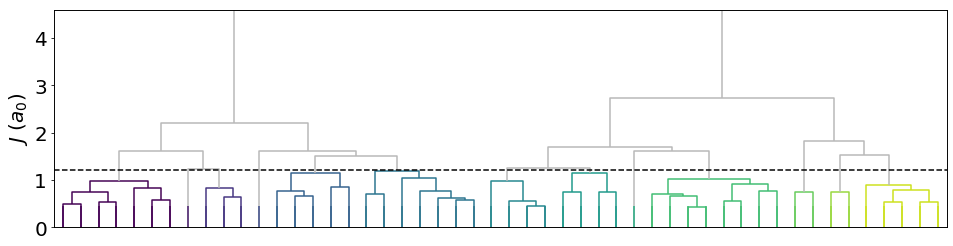

In [7]:
import matplotlib

palette = 'viridis'
n = len(clusters)
cmap = matplotlib.cm.get_cmap(palette)
cflt = [i/n for i in range(n)]
cluster_colours = [matplotlib.colors.to_hex(cmap(i)) for i in cflt]

fragment_order, cluster_order, fragment_colours = plot_dendrogram(link_mat, clusters,
                                                  jthresh, ['FRAG:'+str(i) for i in range(0, nmol)],
                                                  cluster_colours)

Define function for plotting cost function matrix.

In [8]:
def plot_wahba_matrix(jmat, frag_list, display_ticks=False, vmin=0, vmax=0):
    from matplotlib import pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1,1, figsize=(6, 6))

    vmin = min(vmin, jmat.min())
    vmax = max(vmax, jmat.max())

    im = axs.imshow(jmat, cmap='Blues', vmin=vmin, vmax=vmax)

    # plot color bar with same height as graph
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, label="$J_{ij}$ $(a_0)$", cax=cax)

    # if the system is small enough, display fragment labels
    nfrag = len(frag_list)
    if display_ticks:
        axs.set_xticks(range(0, nfrag))
        axs.set_yticks(range(0, nfrag))
        axs.set_xticklabels(["FRAG:"+str(x) for x in frag_list], rotation='vertical')
        axs.set_yticklabels(["FRAG:"+str(x) for x in frag_list])
    else:
        # in this case there are too many fragments to read labels, so turn them off
        axs.get_xaxis().set_ticks([])
        axs.get_yaxis().set_ticks([])
        axs.set_xlabel('Molecule $i$')
        axs.set_ylabel('Molecule $j$')
        
    plt.show()

Reorder the fragments in cluster order, and display the cost matrix.

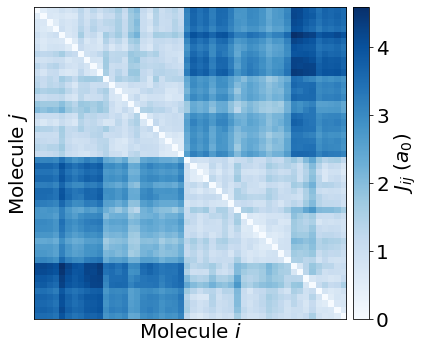

In [9]:
import copy

def reorder_jmat(jmat, fragment_order):
    jmat_reordered = copy.deepcopy(jmat)
    for i,di in enumerate(fragment_order):
        for j,dj in enumerate(fragment_order):
            jmat_reordered[i][j] = jmat[di][dj]
    return jmat_reordered

fragment_order_int = []
for i,dli in enumerate(fragment_order):
    di = int(dli.split(':')[1])
    fragment_order_int.append(di)


jmat_reordered = reorder_jmat(jmat, fragment_order_int)
plot_wahba_matrix(jmat_reordered, fragment_order)